In [12]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_settings_v3 import *
from plot_auxiliary import *
from planar import create_proximity_graph
from fractal import get_box_count, get_cluster_densities
from auxiliary import getLinearReg, get_base_network_name, powerlaw, load_delta_data, read_data_file
from scipy.spatial import Delaunay
#import gif
import matplotlib.animation as animation

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)
animation_dir = os.path.join('..', 'draft', 'figs', 'animations')

In [30]:
def get_label_dict(g):

    components = g.components(mode='WEAK')
    gcc = components.giant()
    membership = np.array(components.membership)
    number, count = np.unique(membership, return_counts=True)
    number = number[np.argsort(count)[::-1]] 
    label_dict = dict((i, n) for i,n in enumerate(number))    
    
    return label_dict, membership
        
def plot(th=None):
    
    ## Spanning subgraph of the removed nodes
    h, max_pos, delta_max = load_delta_data(network, size, param, attack, seed)
    
    position = np.array(h.vs['position'])

    if not th:
        th = max_pos+1
    
    attack_order = h['attack_order']
    to_delete = set(h.vs['oi']).difference(set(attack_order[:th]))
    h.delete_vertices(to_delete)

    backbone_label_dict, backbone_membership = get_label_dict(h)

    ################

    g, _, _ = load_delta_data(network, size, param, attack, seed)    

    label_dict, membership = get_label_dict(g)
    
    g.delete_vertices(attack_order[:th])

    components = g.components(mode='WEAK')
    gcc = components.giant()
    membership = np.array(components.membership)
    number, count = np.unique(membership, return_counts=True)
    number = number[np.argsort(count)[::-1]] 
    count = np.sort(count)[::-1]

    label_dict = dict((i, n) for i,n in enumerate(number))
    for idx in np.where(count==1)[0]:
        label_dict[idx] = -1
        
    
    fig, ax = plt.subplots(figsize=(10,10))

    s0, s1, s2 = marker_sizes[L]

    ticks = [int(i*L/4) for i in range(5)]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.margins(0.01)
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)

    _position = []
    for oi in attack_order[:th]:
        idx = h.vs['oi'].index(oi)
        if backbone_label_dict[backbone_membership[idx]] == 0:
            _position.append(position[oi])
    _position = np.array(_position)
    X, Y = _position[:,0], _position[:,1]
    plt.scatter(X, Y, c='k', marker='*', s=s0, zorder=10)

    _position = []
    for oi in attack_order[:th]:
        idx = h.vs['oi'].index(oi)
        if backbone_label_dict[backbone_membership[idx]] != 0:
            _position.append(position[oi])
    _position = np.array(_position)
    X, Y = _position[:,0], _position[:,1]
    plt.scatter(X, Y, c='0.4', marker='s', s=s1, zorder=5)


    _position = position[attack_order[th:]]
    X, Y = _position[:,0], _position[:,1]
    c_values = []

    for oi in attack_order[th:]:
        idx = g.vs['oi'].index(oi)
        c_values.append(_colors[label_dict[membership[idx]]])
    plt.scatter(
        X, Y, c=c_values, marker='.', s=s2, zorder=0
    )
    fig_name = os.path.join(animation_dir, 'breaking_nodes_{}_{}_{}_{:06d}'.format(network, L, attack, th))

    plt.savefig(fig_name + '.png', dpi=dpi, transparent=False)
    
    return max_pos+1

In [25]:
h, max_pos, delta_max = load_delta_data(network, size, param, attack, seed)
#th = max_pos+1
th = max_pos+1
attack_order = h['attack_order']
to_delete = set(h.vs['oi']).difference(set(attack_order[th:]))
h.delete_vertices(to_delete)

label_dict, membership = get_label_dict(h)

print(pd.Series(membership).value_counts())

h, max_pos, delta_max = load_delta_data(network, size, param, attack, seed)
#th = max_pos+1
th = 2*max_pos+1
attack_order = h['attack_order']
to_delete = set(h.vs['oi']).difference(set(attack_order[th:]))
h.delete_vertices(to_delete)

label_dict, membership = get_label_dict(h)

print(pd.Series(membership).value_counts())

1    2010
0    1951
dtype: int64
5    826
2    780
4    756
3    537
0    516
1    412
dtype: int64


135

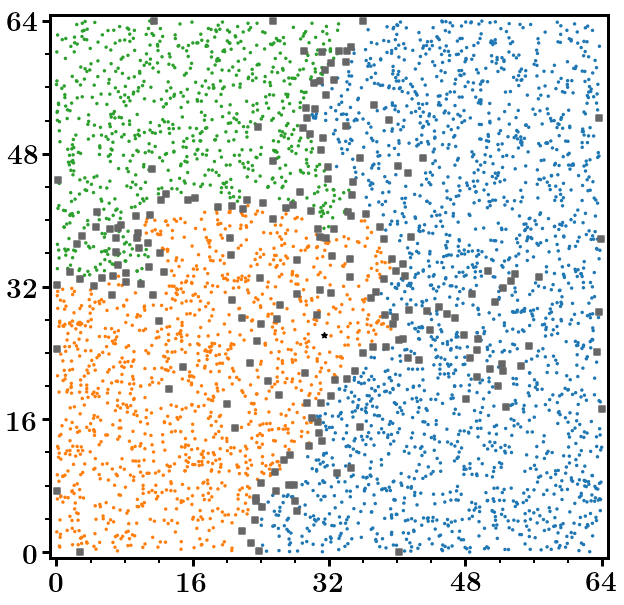

In [32]:
L = 64
N = L*L
attack = 'BtwU'
size = N
network = 'DT'
seed = 0

_colors = 100*[f'C{i}' for i in range(10)]
dpi = 50

marker_sizes = {
    32: [40, 20, 30],
    64: [30, 30, 15],
    128: [20, 10, 6],
    256: [8, 6, 2]
}

plot(200)

In [57]:
g, max_pos, delta_max = load_delta_data(network, size, param, attack, seed)
h, max_pos, delta_max = load_delta_data(network, size, param, attack, seed)

colors = np.zeros(g.vcount(), dtype='object')

th = 2*max_pos + 1

position = np.array(g.vs['position'])
attack_order = g['attack_order']

to_delete = set(g.vs['oi']).difference(set(attack_order[th:]))
g.delete_vertices(to_delete)

to_delete = set(h.vs['oi']).difference(set(attack_order[:th]))
h.delete_vertices(to_delete)


components = g.components(mode='WEAK')
membership = np.array(components.membership)
number, count = np.unique(membership, return_counts=True)
print(membership[:10])
print(number, count)
number = np.argsort(count)[::-1]
label_dict = dict((i, n) for i,n in enumerate(number))

for i, v in enumerate(g.vs()):
    oi = v['oi']
    colors[oi] = f'C{label_dict[membership[i]]}'
    
for i, v in enumerate(h.vs()):
    oi = v['oi']
    colors[oi] = 'k'

number, count

[0 1 1 2 3 0 4 2 0 0]
[0 1 2 3 4 5] [516 412 780 537 756 826]


(array([5, 2, 4, 3, 0, 1]), array([516, 412, 780, 537, 756, 826]))

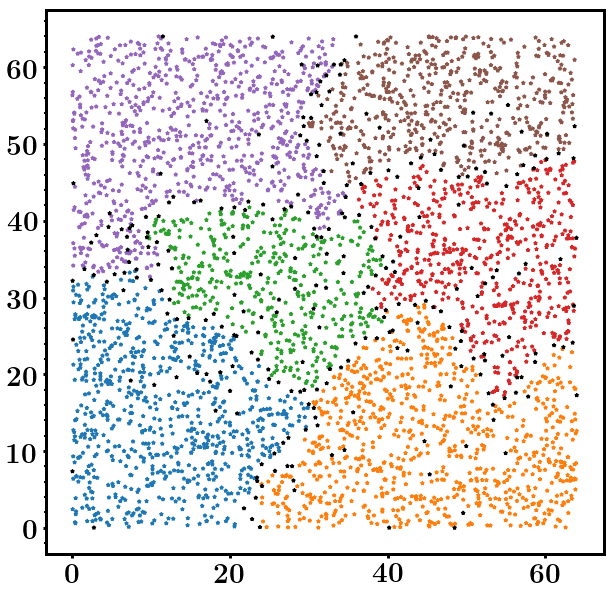

In [58]:
plt.figure(figsize=(10,10))

_position = position[attack_order[th:]]
_colors = colors[attack_order[th:]]
X, Y = _position[:,0], _position[:,1]
#plt.scatter(X, Y, c='C1', marker='*', s=10, zorder=10)
plt.scatter(X, Y, c=_colors, marker='*', s=10, zorder=10)

_position = position[attack_order[:th]]
X, Y = _position[:,0], _position[:,1]
_colors = colors[attack_order[:th]]
plt.scatter(X, Y, c=_colors, marker='*', s=10, zorder=10)

plt.show()

fig size: 72.0 DPI, size in inches [6. 4.]
timestep 0
timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
timestep 0


/media/nahuel/datos/d/anaconda3/envs/networks3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


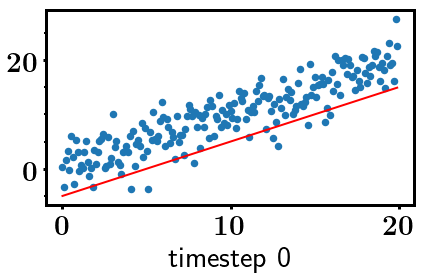

In [37]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

# Plot a scatter that persists (isn't redrawn) and the initial line.
x = np.arange(0, 20, 0.1)
ax.scatter(x, x + np.random.normal(0, 3.0, len(x)))
line, = ax.plot(x, x - 5, 'r-', linewidth=2)

def update(i):
    label = 'timestep {0}'.format(i)
    print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    line.set_ydata(x - 5 + i)
    ax.set_xlabel(label)
    return line, ax

# FuncAnimation will call the 'update' function for each frame; here
# animating over 10 frames, with an interval of 200ms between frames.
anim = FuncAnimation(fig, update, frames=np.arange(0, 10), interval=200)
anim.save('line.gif', dpi=80, writer='imagemagick')

ValueError: Invalid file object: <_io.BufferedReader name=55>

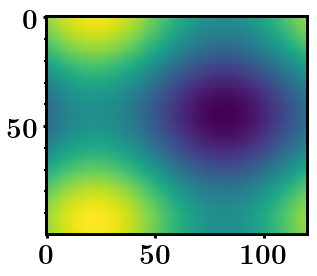

In [35]:
fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

#ani.save('dynamic_images.mp4')
ani.save('dynamic_images.gif')
#plt.show()